In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

# Verifikasi versi TensorFlow
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


In [2]:
# Tentukan path ke folder utama Anda
base_dir = 'dataset_balance' # Ganti dengan nama folder utama Anda

# Buat folder untuk data train dan validation
train_dir = 'data_split_balance/train'
val_dir = 'data_split_balance/validation'

print("Pemisahan data selesai.")

Pemisahan data selesai.


In [3]:
img_height, img_width = 224, 224 # Ukuran input yang direkomendasikan untuk EfficientNetB0
batch_size = 32

# ImageDataGenerator untuk augmentasi data training
train_datagen = ImageDataGenerator(
    # Hapus rescale=1./255 dari sini
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input # <--- PENTING: Gunakan preprocessing_function dari EfficientNet
)

# ImageDataGenerator untuk data validation (hanya normalisasi)
val_datagen = ImageDataGenerator(
    # Hapus rescale=1./255 dari sini
    preprocessing_function=preprocess_input # <--- PENTING: Gunakan preprocessing_function dari EfficientNet
)

# Load data dari folder
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical', # Karena Anda memiliki 3 kelas
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Penting untuk evaluasi
)

# Hitung class weights untuk menangani dataset tidak seimbang
from sklearn.utils import class_weight

# Dapatkan label kelas dari generator
labels = train_generator.classes
# Dapatkan mapping indeks ke nama kelas
class_labels = list(train_generator.class_indices.keys())

# Hitung bobot kelas
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(zip(np.unique(labels), class_weights))

print(f"Class Weights: {class_weights}")
print(f"Number of classes: {train_generator.num_classes}")

Found 1082 images belonging to 3 classes.
Found 272 images belonging to 3 classes.
Class Weights: {np.int32(0): np.float64(0.8196969696969697), np.int32(1): np.float64(0.996316758747698), np.int32(2): np.float64(1.2880952380952382)}
Number of classes: 3


In [4]:
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# --- Menggunakan Learning Rate yang Lebih Kecil (Saran dari Pembahasan Sebelumnya) ---
model.compile(optimizer=Adam(learning_rate=0.0001), # Learning rate yang lebih kecil
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [5]:
epochs = 20 # Mungkin tingkatkan epoch sedikit karena learning rate lebih kecil

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    class_weight=class_weights,
    verbose=1
)

c:\Users\WINDOWS 11\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.4395 - loss: 1.1559 - val_accuracy: 0.7500 - val_loss: 0.6749
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.6947 - loss: 0.7251 - val_accuracy: 0.8162 - val_loss: 0.5429
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.7846 - loss: 0.5626 - val_accuracy: 0.8125 - val_loss: 0.4621
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.8361 - loss: 0.4772 - val_accuracy: 0.8493 - val_loss: 0.4054
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.8205 - loss: 0.4408 - val_accuracy: 0.8235 - val_loss: 0.4173
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8402 - loss: 0.4160 - val_accuracy: 0.8235 - val_loss: 0.4428
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8299 - loss: 0.3928 - val_accuracy: 0.8456 - val_loss: 0.3657
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8423 - loss: 0.4006 - val_accuracy: 0.8529 - val_loss

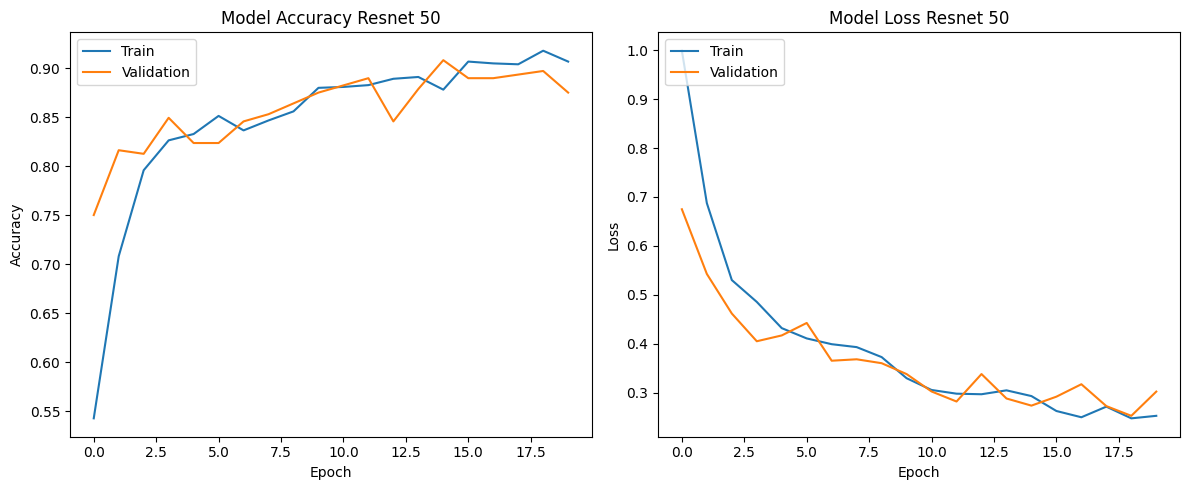

In [6]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Resnet 50')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Resnet 50')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [7]:
# Dapatkan prediksi dari data validasi
Y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true_classes = val_generator.classes

# Dapatkan nama kelas
target_names = list(val_generator.class_indices.keys())

# Tampilkan classification report
print("--- Classification Report ---")
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step
--- Classification Report ---
              precision    recall  f1-score   support

       sehat       0.90      0.98      0.94       111
 tumor_ganas       1.00      0.77      0.87        91
 tumor_jinak       0.73      0.84      0.78        70

    accuracy                           0.88       272
   macro avg       0.88      0.86      0.86       272
weighted avg       0.89      0.88      0.88       272



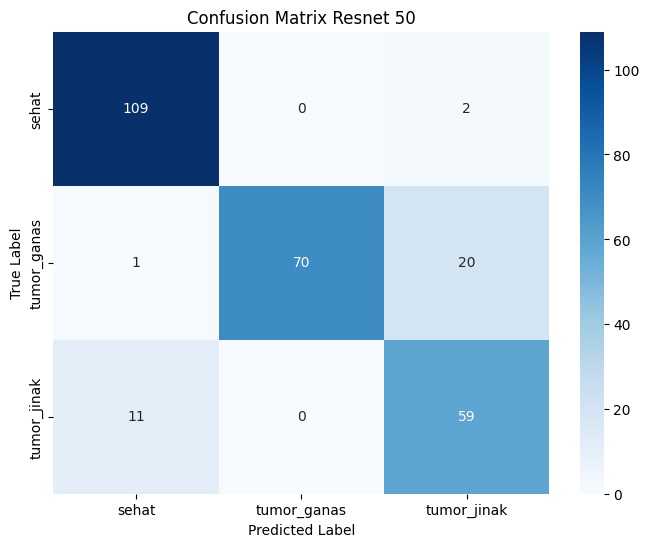

In [8]:
# Hitung confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Tampilkan confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix Resnet 50')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

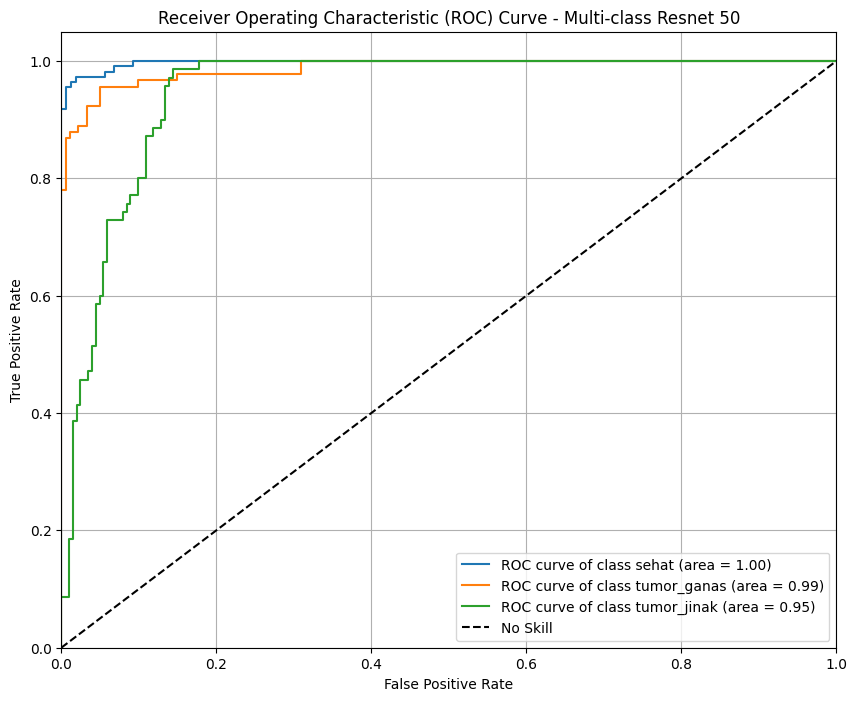

Overall AUC (Micro-average): 0.97


In [9]:
# ROC Curve untuk multi-kelas (One-vs-Rest)
plt.figure(figsize=(10, 8))

for i in range(len(target_names)):
    # Binarize the true labels for one-vs-rest
    y_true_binarized = (y_true_classes == i).astype(int)
    # Get the probability scores for the current class
    y_score = Y_pred[:, i]

    fpr, tpr, _ = roc_curve(y_true_binarized, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'ROC curve of class {target_names[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-class Resnet 50')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Calculate overall AUC score (micro-average for multi-class)
y_true_one_hot = tf.keras.utils.to_categorical(y_true_classes, num_classes=len(target_names))
auc_score_micro = roc_auc_score(y_true_one_hot, Y_pred, average='micro')
print(f"Overall AUC (Micro-average): {auc_score_micro:.2f}")

In [10]:
model.save('ResNet50.h5')

In [11]:
base_model = ResNet101(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# --- Menggunakan Learning Rate yang Lebih Kecil (Saran dari Pembahasan Sebelumnya) ---
model.compile(optimizer=Adam(learning_rate=0.0001), # Learning rate yang lebih kecil
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [12]:
epochs = 20 # Mungkin tingkatkan epoch sedikit karena learning rate lebih kecil

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 159s 4s/step - accuracy: 0.4631 - loss: 1.1948 - val_accuracy: 0.7022 - val_loss: 0.6920
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.6792 - loss: 0.7215 - val_accuracy: 0.8088 - val_loss: 0.4991
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.8039 - loss: 0.5325 - val_accuracy: 0.8309 - val_loss: 0.4470
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.7992 - loss: 0.5097 - val_accuracy: 0.8419 - val_loss: 0.4347
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.8196 - loss: 0.4714 - val_accuracy: 0.8419 - val_loss: 0.4038
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.8572 - loss: 0.3929 - val_accuracy: 0.8235 - val_loss: 0.4197
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.8474 - loss: 0.3962 - val_accuracy: 0.8713 - val_loss: 0.3572
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.8631 - loss: 0.3864 - val_accuracy: 0.8566 - v

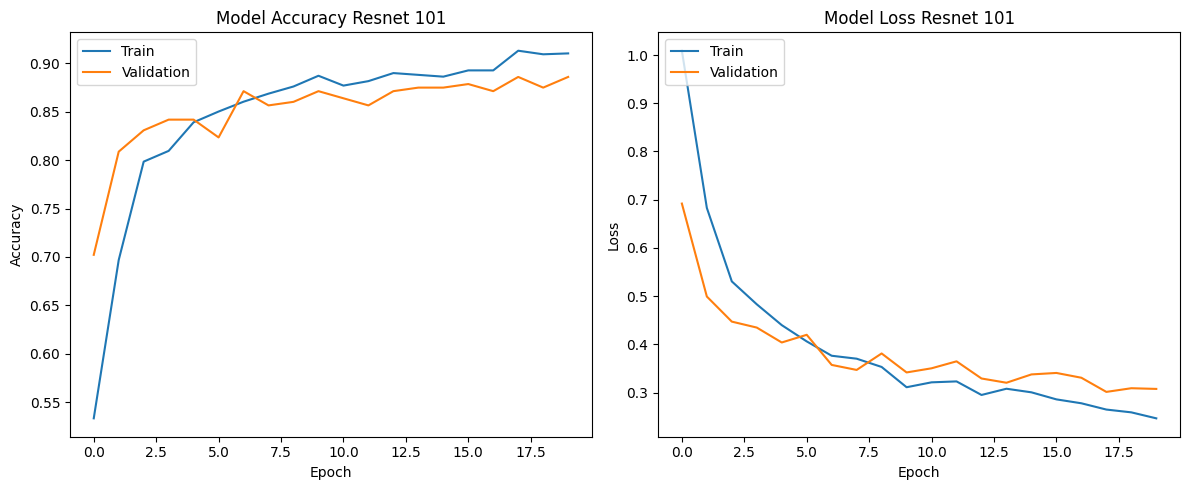

In [13]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Resnet 101')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Resnet 101')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [14]:
# Dapatkan prediksi dari data validasi
Y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true_classes = val_generator.classes

# Dapatkan nama kelas
target_names = list(val_generator.class_indices.keys())

# Tampilkan classification report
print("--- Classification Report ---")
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step
--- Classification Report ---
              precision    recall  f1-score   support

       sehat       0.91      0.96      0.93       111
 tumor_ganas       0.96      0.84      0.89        91
 tumor_jinak       0.77      0.83      0.80        70

    accuracy                           0.89       272
   macro avg       0.88      0.88      0.88       272
weighted avg       0.89      0.89      0.89       272



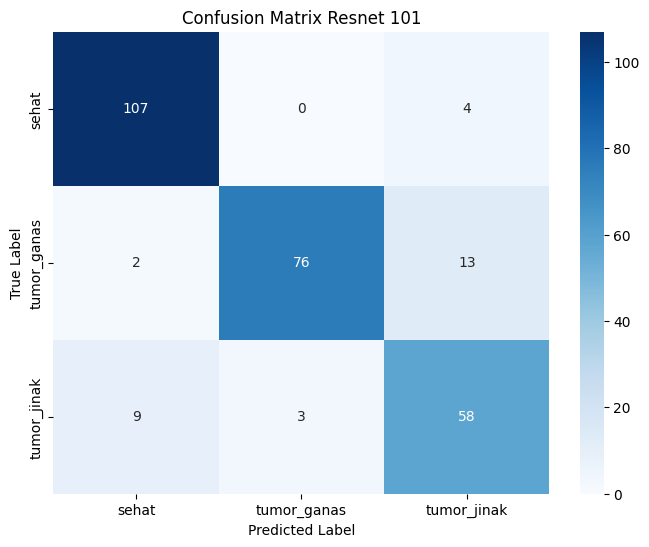

In [15]:
# Hitung confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Tampilkan confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix Resnet 101')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

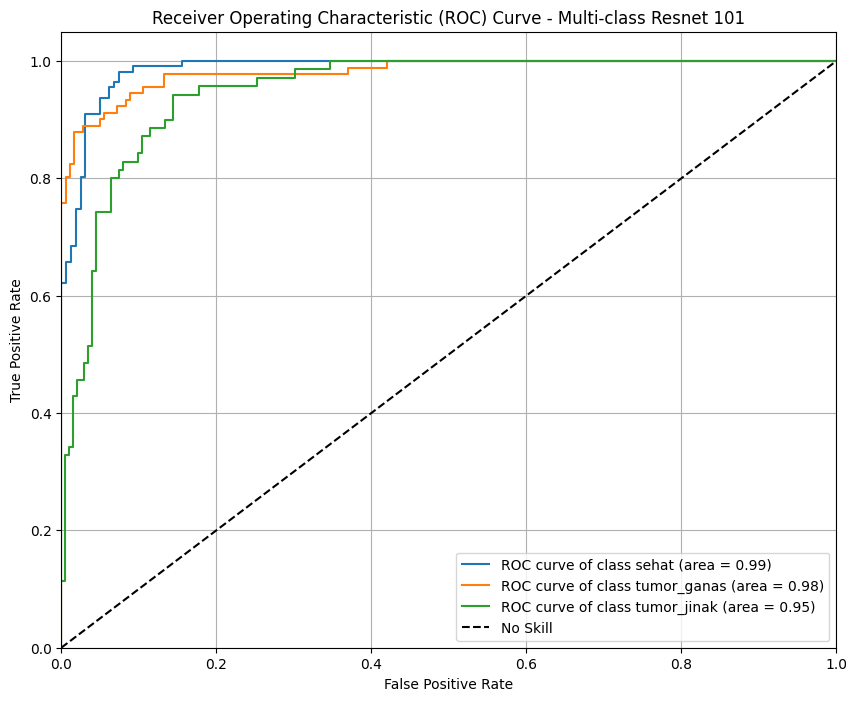

Overall AUC (Micro-average): 0.97


In [16]:
# ROC Curve untuk multi-kelas (One-vs-Rest)
plt.figure(figsize=(10, 8))

for i in range(len(target_names)):
    # Binarize the true labels for one-vs-rest
    y_true_binarized = (y_true_classes == i).astype(int)
    # Get the probability scores for the current class
    y_score = Y_pred[:, i]

    fpr, tpr, _ = roc_curve(y_true_binarized, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'ROC curve of class {target_names[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-class Resnet 101')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Calculate overall AUC score (micro-average for multi-class)
y_true_one_hot = tf.keras.utils.to_categorical(y_true_classes, num_classes=len(target_names))
auc_score_micro = roc_auc_score(y_true_one_hot, Y_pred, average='micro')
print(f"Overall AUC (Micro-average): {auc_score_micro:.2f}")

In [17]:
model.save('ResNet101.h5')

In [18]:
base_model = ResNet152(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# --- Menggunakan Learning Rate yang Lebih Kecil (Saran dari Pembahasan Sebelumnya) ---
model.compile(optimizer=Adam(learning_rate=0.0001), # Learning rate yang lebih kecil
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [19]:
epochs = 20 # Mungkin tingkatkan epoch sedikit karena learning rate lebih kecil

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 242s 7s/step - accuracy: 0.4829 - loss: 1.1351 - val_accuracy: 0.7904 - val_loss: 0.6215
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 215s 6s/step - accuracy: 0.7360 - loss: 0.6880 - val_accuracy: 0.8162 - val_loss: 0.4838
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 216s 6s/step - accuracy: 0.7885 - loss: 0.5490 - val_accuracy: 0.8419 - val_loss: 0.4232
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 216s 6s/step - accuracy: 0.8090 - loss: 0.4757 - val_accuracy: 0.8603 - val_loss: 0.3840
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 296s 9s/step - accuracy: 0.8296 - loss: 0.4358 - val_accuracy: 0.8529 - val_loss: 0.3940
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 239s 7s/step - accuracy: 0.8627 - loss: 0.4263 - val_accuracy: 0.8640 - val_loss: 0.3360
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 211s 6s/step - accuracy: 0.8434 - loss: 0.4125 - val_accuracy: 0.8750 - val_loss: 0.3337
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 227s 7s/step - accuracy: 0.8521 - loss: 0.3905 - val_accuracy: 0.8787 - v

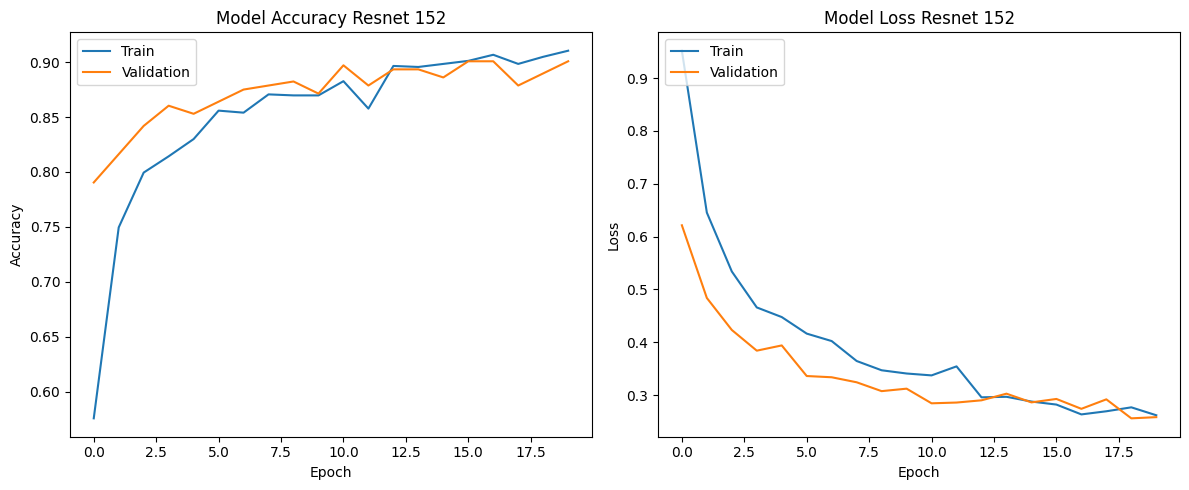

In [20]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Resnet 152')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Resnet 152')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [21]:
# Dapatkan prediksi dari data validasi
Y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true_classes = val_generator.classes

# Dapatkan nama kelas
target_names = list(val_generator.class_indices.keys())

# Tampilkan classification report
print("--- Classification Report ---")
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step
--- Classification Report ---
              precision    recall  f1-score   support

       sehat       0.92      0.96      0.94       111
 tumor_ganas       0.97      0.86      0.91        91
 tumor_jinak       0.79      0.86      0.82        70

    accuracy                           0.90       272
   macro avg       0.90      0.89      0.89       272
weighted avg       0.91      0.90      0.90       272



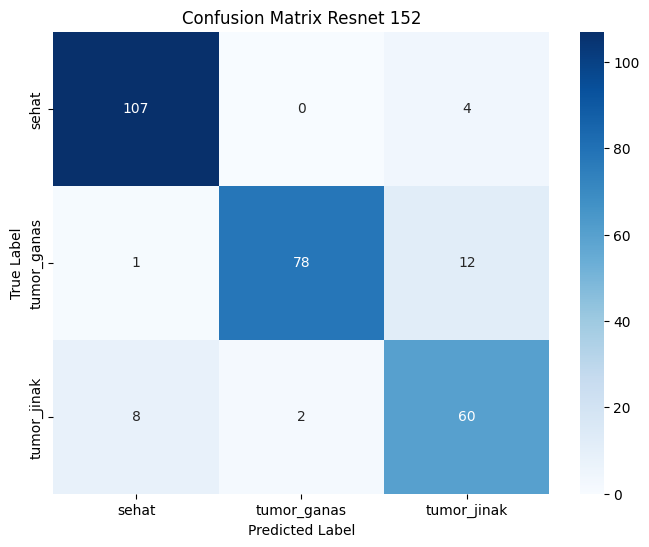

In [22]:
# Hitung confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Tampilkan confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix Resnet 152')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

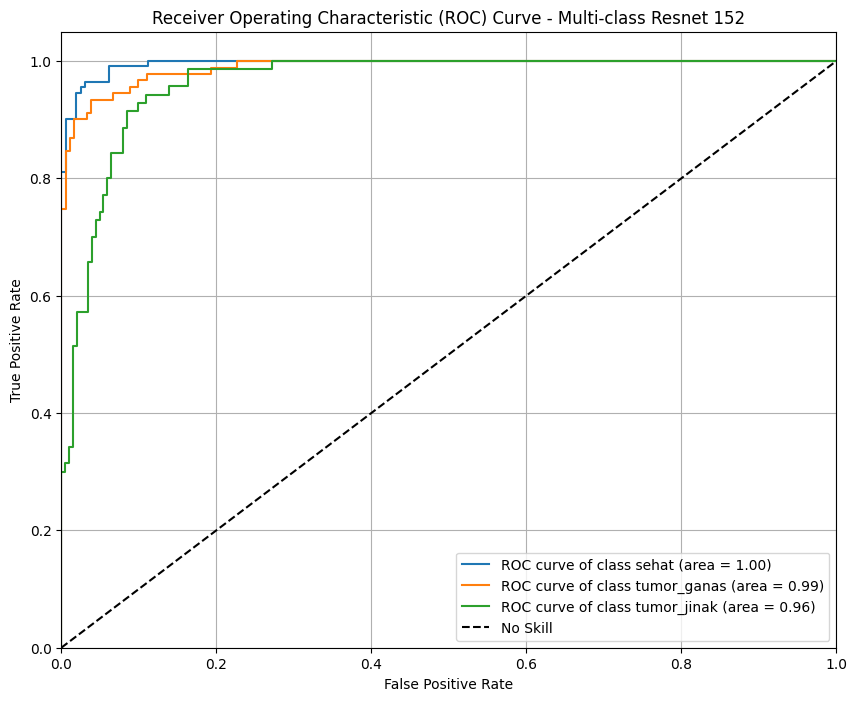

Overall AUC (Micro-average): 0.98


In [23]:
# ROC Curve untuk multi-kelas (One-vs-Rest)
plt.figure(figsize=(10, 8))

for i in range(len(target_names)):
    # Binarize the true labels for one-vs-rest
    y_true_binarized = (y_true_classes == i).astype(int)
    # Get the probability scores for the current class
    y_score = Y_pred[:, i]

    fpr, tpr, _ = roc_curve(y_true_binarized, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'ROC curve of class {target_names[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-class Resnet 152')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Calculate overall AUC score (micro-average for multi-class)
y_true_one_hot = tf.keras.utils.to_categorical(y_true_classes, num_classes=len(target_names))
auc_score_micro = roc_auc_score(y_true_one_hot, Y_pred, average='micro')
print(f"Overall AUC (Micro-average): {auc_score_micro:.2f}")

In [24]:
model.save('ResNet152.h5')